# Segmentación de Clientes con modelo K-means

En este notebook hemos intentado segmentar los clientes en grupos homogéneos según comportamientos de compra y preferencias con el modelo de aprendizaje no supervisado K-means. Esto nos va a permitir personalizar estrategias de marketing para cada segmento. Los elementos recomendados pueden basarse en las preferencias del grupo al que pertenece el cliente. 

IMPORTAMOS LAS LIBRERIAS QUE NECESITAMOS

In [1]:
import pandas as pd
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

LEEMOS EL DATAFRAME Y ASIGNAMOS A LAS COLUMNAS TIPO DE DATOS 

In [2]:
tienda = pd.read_csv('tienda.csv')
tipos_de_datos = {
    'ID_PRODUCTO': 'object',
    'NOMBRE_PRODUCTO': 'object',
    'FECHA_COMPRA': 'datetime64[ns]',
    'CANAL_VENTA': 'object',
    'CADUCIDAD': 'datetime64[ns]',
    'CANTIDAD': 'float64',
    'PRECIO_UNIDAD': 'float64',
    'PRECIO_TOTAL': 'float64',
    'INDEX_CLIENTES': 'int32',
    'ETIQUETA_CANAL': 'int64',
    'CATEGORIA': 'object',
    'PROVEEDOR': 'object',
    'UNIDADES_VENDIDAS': 'object'
}
tienda = tienda.astype(tipos_de_datos)
tienda = tienda.loc[tienda['CANTIDAD'] >= 0]

C:\Users\ladac\AppData\Local\Temp\ipykernel_17504\889632423.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  tienda = pd.read_csv('tienda.csv')


CREAMOS UN NUEVO DATAFRAME PARA PODER UTILIZARLO EN EL MODELO 

In [3]:
# Como no disponemos de datos sobre los clientes de la tienda fisica y de la pagina web, vamos a utilizar solo los clientes de almacen que son etiquetados
clientes = tienda[tienda['ETIQUETA_CANAL']== 3]
clientes.drop(['PROVEEDOR', 'UNIDADES_VENDIDAS', 'CADUCIDAD', 'CANAL_VENTA'], axis = 1, inplace=True) # eliminamos las columnas que no nos aporta ninguna informacion valiosa

C:\Users\ladac\AppData\Local\Temp\ipykernel_17504\2786736669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes.drop(['PROVEEDOR', 'UNIDADES_VENDIDAS', 'CADUCIDAD', 'CANAL_VENTA'], axis = 1, inplace=True) # eliminamos las columnas que no nos aporta ninguna informacion valiosa


In [4]:
# Desde el dataframe filtrado sacamos la informacion que nos interesa 
# La cantidad comprada en todo el período
clientes_cantidad= clientes.groupby('INDEX_CLIENTES').agg({
    'CANTIDAD': 'sum'
}).reset_index()
clientes_cantidad.rename(columns={'CANTIDAD': 'CANTIDAD_TOTAL_COMPRADO'}, inplace=True)

#El número total de compras por cliente
clientes_numero_compras= clientes.groupby('INDEX_CLIENTES').agg({
    'FECHA_COMPRA': 'count'
}).reset_index()
clientes_numero_compras.rename(columns={'FECHA_COMPRA': 'NUMERO_COMPRAS'}, inplace=True)

# El gasto total por cliente
clientes_gastos = clientes.groupby('INDEX_CLIENTES').agg({
    'PRECIO_TOTAL': 'sum'
}).reset_index()
clientes_gastos.rename(columns={'PRECIO_TOTAL': 'GASTOS_TOTALES'}, inplace=True)

# Identificar la categoría más comprada por cada cliente
categoria = clientes.groupby(['INDEX_CLIENTES', 'CATEGORIA']).agg({
    'CANTIDAD': 'sum'
}).reset_index()
idx = categoria.groupby('INDEX_CLIENTES')['CANTIDAD'].idxmax()
clientes_categoria= categoria.loc[idx]
clientes_categoria.drop(['CANTIDAD'], axis=1, inplace=True)
clientes_categoria.rename(columns={'CATEGORIA': 'CATEGORIA_MAS_COMPRADA'}, inplace=True)

# Identificar el producto más comprado por cada cliente
product = clientes.groupby(['INDEX_CLIENTES', 'ID_PRODUCTO']).agg({
    'CANTIDAD': 'sum'
}).reset_index()
idx_product = product.groupby('INDEX_CLIENTES')['CANTIDAD'].idxmax()
clientes_product = product.loc[idx_product]
clientes_product.drop(['CANTIDAD'], axis=1, inplace=True)
clientes_product.rename(columns={'ID_PRODUCTO': 'PRODUCTO_MAS_COMPRADO'}, inplace=True)

In [5]:
# Realizamos la unión acumulativa de todos los DataFrames en la lista
dataframes = [clientes_cantidad, clientes_numero_compras, clientes_gastos, clientes_categoria, clientes_product]
columna_comun = 'INDEX_CLIENTES'
df_final = reduce(lambda left, right: pd.merge(left, right, on=columna_comun, how='outer'), dataframes)
df_final

,INDEX_CLIENTES,CANTIDAD_TOTAL_COMPRADO,NUMERO_COMPRAS,GASTOS_TOTALES,CATEGORIA_MAS_COMPRADA,PRODUCTO_MAS_COMPRADO
0,1,38.96,24,78.18,Productos lacteos,00007898
1,2,3741.53,787,8642.61,Dulces,00025178
2,3,5720.66,44,7668.33,Productos lacteos,00026897
3,4,9042.49,165,14686.28,Productos lacteos,00026897
4,5,67.29,46,191.62,Productos lacteos,00000617
...,...,...,...,...,...,...
134,137,1359.91,306,2752.40,Productos lacteos,00008474
135,138,20.00,1,102.96,Productos Congelados,00194081
136,139,48.00,1,247.10,Productos Congelados,00194081
137,140,111.99,25,151.88,Dulces,00002816


Utilizamos el método del codo (Elbow Method) para determinar el número óptimo de clústeres (k) en el conjunto de datos. El método del codo ayuda a identificar el valor de k en el cual la inercia (suma de cuadrados intra-cluster) comienza a disminuir a una tasa más lenta.

C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

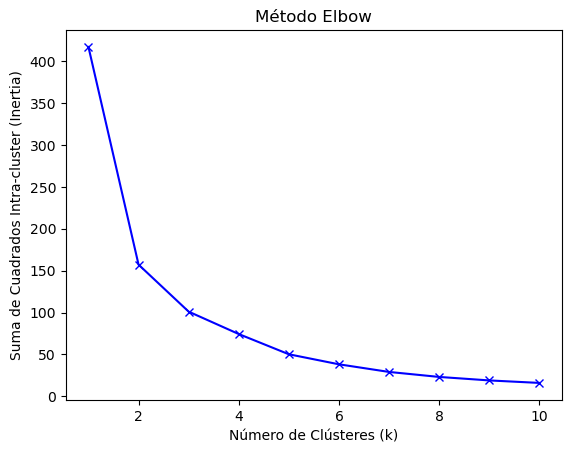

In [6]:
# Definimos las características
features = ['CANTIDAD_TOTAL_COMPRADO', 'NUMERO_COMPRAS', 'GASTOS_TOTALES']
nuevo = df_final[features]
X = nuevo
# Escalamos las características utilizando StandardScaler para asegurarnos de que todas tengan la misma escala. Esto es importante para algoritmos basados en la distancia, como K-means.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Aplicamos el método del codo para encontrar el número óptimo de clústeres. La inercia (suma de cuadrados intra-cluster) se guarda en la lista inertia para cada k.
K = range(1, 11)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
# Visualizamos los resultados del método del codo
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Suma de Cuadrados Intra-cluster (Inertia)')
plt.title('Método Elbow')
plt.show()

ENTRENAMOS EL MODELO

In [7]:
# Definimos el número optimo de clústeres
numero_optimo_clusters = 4
# Entrenamos el modelo K-Means con el número óptimo de clústeres
kmeans_model = KMeans(n_clusters=numero_optimo_clusters, random_state=42)
kmeans_model.fit(X_scaled)
# Agregamos las etiquetas de clúster a cada cliente del dataframe original
df_final['Cluster'] = kmeans_model.labels_

C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
# Calculamos dos métricas comunes utilizadas para evaluar la calidad de los clústeres obtenidos mediante el algoritmo K-Means
# La inercia es la suma de las distancias al cuadrado entre cada punto de datos y el centroide de su clúster más cercano
inertia = kmeans_model.inertia_
print(f"Inercia: {inertia}")

# La puntuación de silueta es una medida que cuantifica cuán similar es un punto a su propio clúster (cohesión) en comparación con otros clústeres (separación)
silhouette = silhouette_score(X_scaled, kmeans_model.labels_)
print(f"Puntuación de Silueta: {silhouette}")

Inercia: 74.35942393909892
Puntuación de Silueta: 0.6037098544178954


GRAFICAMOS LOS CLUSTERS

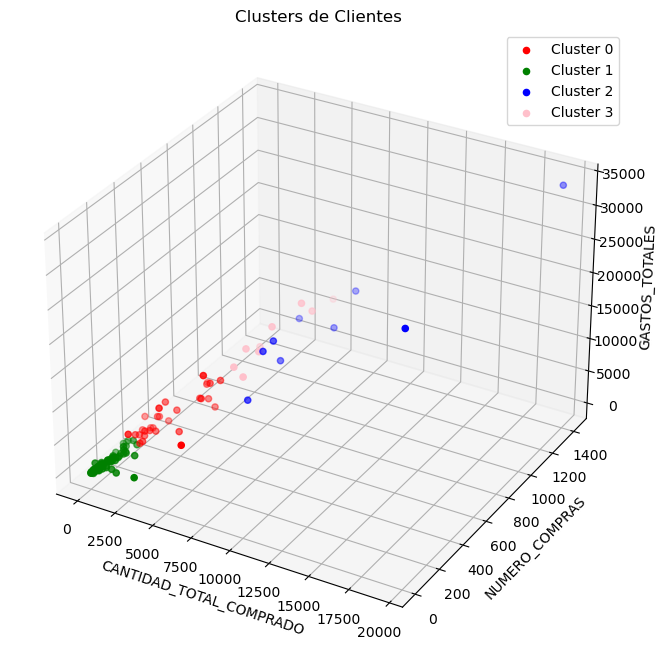

In [9]:
# Creamos un gráfico tridimensional (3D) para visualizar los clústeres generados por el modelo K-Means. 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Asignar colores diferentes a cada clúster
colors = ['red', 'green', 'blue', 'pink']
for cluster, color in zip(range(numero_optimo_clusters), colors):
    cluster_data = df_final[df_final['Cluster'] == cluster]
    ax.scatter(cluster_data['CANTIDAD_TOTAL_COMPRADO'], cluster_data['NUMERO_COMPRAS'], cluster_data['GASTOS_TOTALES'], c=color, label=f'Cluster {cluster}')
# Etiquetas y título
ax.set_xlabel('CANTIDAD_TOTAL_COMPRADO')
ax.set_ylabel('NUMERO_COMPRAS')
ax.set_zlabel('GASTOS_TOTALES')
ax.set_title('Clusters de Clientes')

# Leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ladac\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


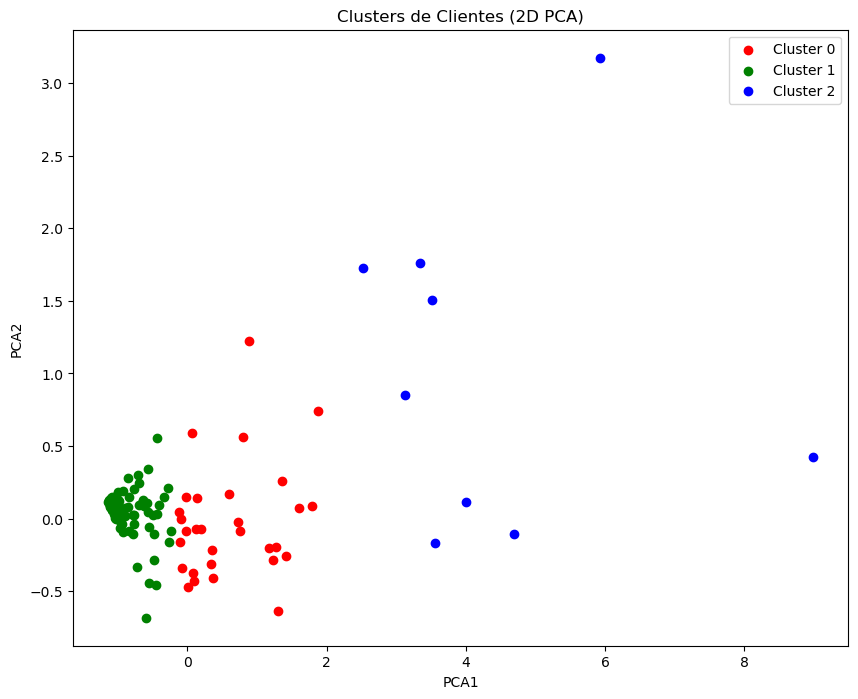

In [10]:
# Aplicamos PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Añadimos las componentes PCA al DataFrame original
df_final['PCA1'] = X_pca[:, 0]
df_final['PCA2'] = X_pca[:, 1]

# Número óptimo de clústeres identificado a través del método del codo
numero_optimo_clusters = 4

# Entrenamos el modelo K-Means con el número óptimo de clústeres
kmeans_model = KMeans(n_clusters=numero_optimo_clusters, random_state=42)
kmeans_model.fit(X_scaled)

# Visualizamos los clusters en un gráfico de dispersión 2D con PCA
plt.figure(figsize=(10, 8))

# Asignamos colores diferentes a cada clúster
colors = ['red', 'green', 'blue']
for cluster, color in zip(range(numero_optimo_clusters), colors):
    cluster_data = df_final[df_final['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], c=color, label=f'Cluster {cluster}')

# Etiquetas y título
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters de Clientes (2D PCA)')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Un breve analisis de las caracteristicas de los clusters

In [11]:
# Calculamos las características promedio de cada cluster para entender las diferencias entre ellos
perfiles_cluster = df_final.groupby('Cluster').mean()
columnas = ['CANTIDAD_TOTAL_COMPRADO', 'NUMERO_COMPRAS', 'GASTOS_TOTALES']
perfiles_cluster[columnas]

C:\Users\ladac\AppData\Local\Temp\ipykernel_17504\3547486617.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  perfiles_cluster = df_final.groupby('Cluster').mean()


,CANTIDAD_TOTAL_COMPRADO,NUMERO_COMPRAS,GASTOS_TOTALES
Cluster,,,
0,2840.661000,287.466667,5928.056667
1,425.184505,53.560440,708.850000
2,11168.152222,601.111111,20558.397111
3,4551.330000,914.888889,9027.130000


Conclusion: 
Cluster 0:  Este cluster tiene un valor moderadamente alto para la cantidad total comprada, un número moderado de compras y un gasto promedio. Podría representar clientes que compran con frecuencia y gastan de manera consistente.
Cluster 1: Este cluster tiene valores más bajos en todas las características en comparación con los demás clústeres. Podría representar clientes menos activos o que realizan compras más pequeñas y menos frecuentes.
Cluster 2: Este cluster tiene valores muy altos para la cantidad total comprada y los gastos totales, con un número moderado de compras. Podría representar clientes de alto valor que realizan compras significativas y frecuentes.
Cluster 3: Este cluster tiene valores moderadamente altos en todas las características, con un número más alto de compras y un gasto significativo. Podría representar clientes activos que realizan compras frecuentes y de mayor tamaño.
Estos resultados proporcionan una visión general de cómo se comportan los diferentes clústeres en relación con las características seleccionadas.

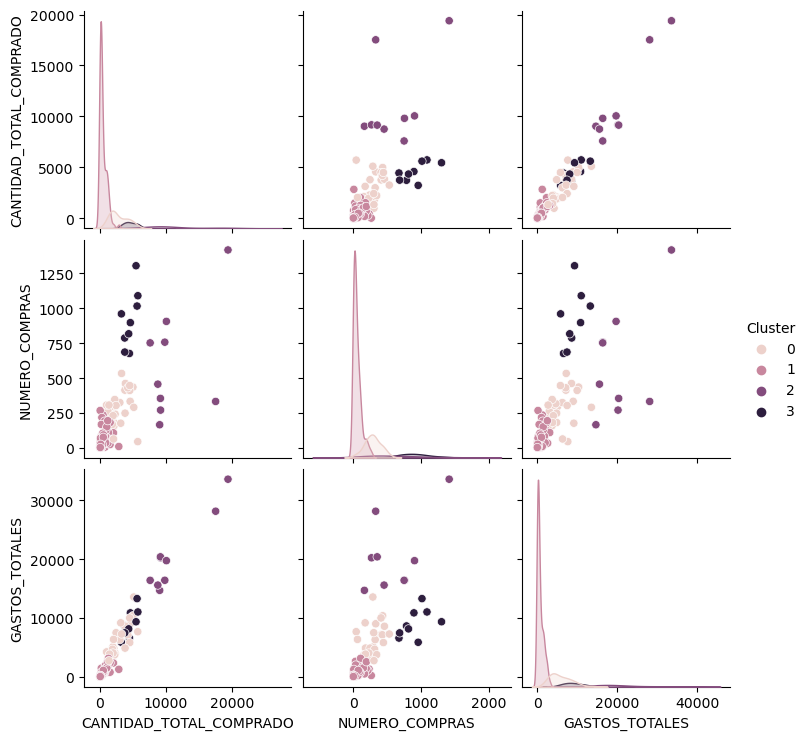

In [12]:
#Visualizacion para entender la distribución de las características en cada cluster.
sns.pairplot(df_final, hue='Cluster', vars=['CANTIDAD_TOTAL_COMPRADO', 'NUMERO_COMPRAS', 'GASTOS_TOTALES'])
plt.show()

# CONCLUSIÓN

La inercia de 74.36 indica que, en promedio, los puntos dentro de cada clúster están a esa distancia al cuadrado de su centroide más cercano. Para interpretar si esta inercia es baja o alta, se compararía con otros conjuntos de datos o modelos con diferentes números de clústeres.
Una puntuación de silueta de 0.60 es generalmente considerada como bastante buena. Indica que los puntos están bien asignados a sus clústeres y están separados de otros clústeres.
El Cluster 2 destaca por tener los valores más altos en todas las características, sugiriendo un grupo de clientes de alto valor.
El Cluster 1 muestra valores bajos en todas las características, indicando un grupo de clientes menos activos o con compras más modestas.
Los Clusters 0 y 3 tienen valores moderadamente altos, pero pueden diferir en términos de la frecuencia de las compras y los gastos totales.